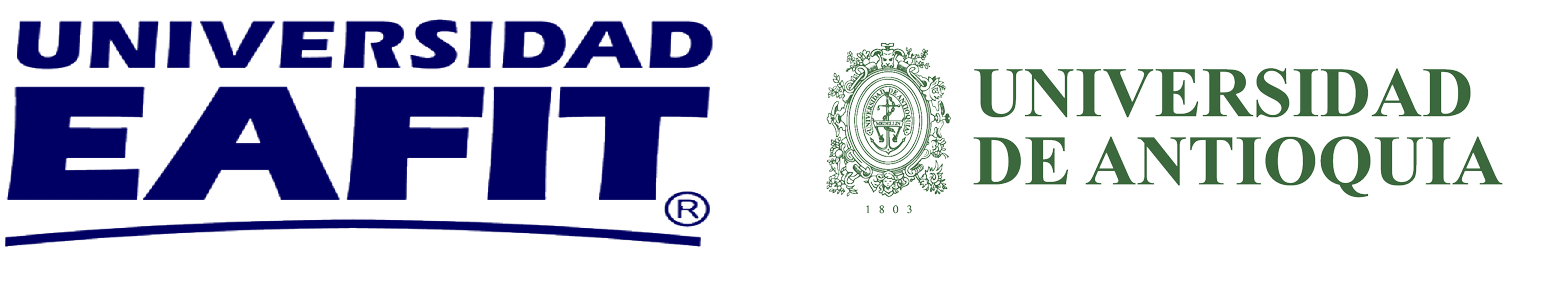

## Proyecto Humath

**Grupo  Bioseñales**

notebook para demo de la detección de tres tipos de arritmias (Bradicardia, taquicardia) a partir de señales PPG y ABP.

In [ ]:
!pip install wfdb
!pip install neurokit2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 10.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 9.1 MB/s 


In [ ]:
import numpy as np
from scipy.io import loadmat
from ipywidgets import interact
import wfdb
import os
import sys
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

Descarguemos la base de datos Cardiology de MIMIC-III

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=13SB6ynb-QlCNq6I5GFU3YwIW0hJ371m3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=13SB6ynb-QlCNq6I5GFU3YwIW0hJ371m3" -O "training.zip" && rm -rf /tmp/cookies.txt

--2022-11-18 04:06:59--  https://docs.google.com/uc?export=download&confirm=t&id=13SB6ynb-QlCNq6I5GFU3YwIW0hJ371m3
Resolving docs.google.com (docs.google.com)... 74.125.143.100, 74.125.143.101, 74.125.143.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.143.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-7g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ph36agf90k403pkpr4v08k6snu71kvlu/1668744375000/08333744685695600646/*/13SB6ynb-QlCNq6I5GFU3YwIW0hJ371m3?e=download&uuid=c01ee565-4d07-4d2f-8bf8-1aacb1929c68 [following]
--2022-11-18 04:06:59--  https://doc-00-7g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ph36agf90k403pkpr4v08k6snu71kvlu/1668744375000/08333744685695600646/*/13SB6ynb-QlCNq6I5GFU3YwIW0hJ371m3?e=download&uuid=c01ee565-4d07-4d2f-8bf8-1aacb1929c68
Resolving doc-00-7g-docs.googleusercontent.com (doc-00-7g-docs.googleusercontent.com)... 108.177.119.132,

In [ ]:
# Funciones para análisis de anomalías
!rm -rf Humath
!git clone https://github.com/juliangilg/Humath
sys.path.append('Humath/Functions')
from FeatureExtraction import featureextraction
from ArritmiaDetection import ArritmiaDetection

Cloning into 'Humath'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 127 (delta 23), reused 59 (delta 21), pack-reused 61
Receiving objects: 100% (127/127), 45.66 KiB | 531.00 KiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
!unzip training.zip -d training

In [ ]:
arr = os.listdir('./training/training')

In [ ]:
path = './training/training/'
signals_count = []
signals_ = []
Label = []
list_files = [f for f in os.listdir(path) if f.endswith('.hea')]
Fs = 250 # frecuencia de muestreo.  
for nfile in list_files:
  signals, fields = wfdb.rdsamp(os.path.join(path, nfile[:-4]))
  typeSig_n = fields['sig_name']
  if (typeSig_n.count('PLETH')) | (typeSig_n.count('ABP')):
    # print(nfile)
    list_arr = ['Tachycardia', 'Bradycardia', 'Asystole']
    exist_count = list_arr.count(fields['comments'][0])
    if exist_count > 0:
      IDX = []
      Sig = []
      try:
        idx_ppg = typeSig_n.index('PLETH')
        IDX.append(idx_ppg)
        Sig.append('PLETH')
      except:
          pass
      try:
        idx_abp = typeSig_n.index('ABP')
        IDX.append(idx_abp)
        Sig.append('ABP')
      except:
          pass
      # print(IDX)
      signals_.append(signals[70000:75000, IDX])
      signals_count.append(Sig)
      Label.append([fields['comments'][0],fields['comments'][1]])
  #print(typeSig_n)

In [ ]:
# Se elijen únicamente las señales con taquicardia, bradicardia o normales.
signals_1 = [sig for i, sig in enumerate(signals_) \
             if  (Label[i][0] != 'Asystole') | (Label[i][1] == 'False alarm')]
Labels_1  = [Label[i] for i, _ in enumerate(signals_) \
             if  (Label[i][0] != 'Asystole') | (Label[i][1] == 'False alarm')]
signals_count_ = [signals_count[i] for i, _ in enumerate(signals_) \
             if  (Label[i][0] != 'Asystole') | (Label[i][1] == 'False alarm')]

lab = {'Tachycardia':1, 'Bradycardia': 2}
Y  = np.zeros(len(Labels_1))
df = pd.DataFrame(columns=('PLETH', 'ABP'))
for i, sig in enumerate(signals_1):

  if Labels_1[i][1] == 'False alarm':
    Y[i] = 0
  else:
    Y[i] = lab[Labels_1[i][0]]
  
  if len(signals_count_[i]) == 1:
    df.loc[i, signals_count_[i]] = [sig]
  else:
    df.loc[i, signals_count_[i][0]] = [sig[:,0:1]]
    df.loc[i, signals_count_[i][1]] = [sig[:,1:2]]

  

In [ ]:
import itertools

regular_list = signals_count_
flat_list = list(itertools.chain(*regular_list))

# importing Counter module
from collections import Counter
 
# creating a list with the keys

rep = Counter(flat_list)
print('Repeticiones por tipo de bioseñal: ',rep)

Repeticiones por tipo de bioseñal:  Counter({'PLETH': 279, 'ABP': 125})


### 1. Análisis con múltiples señales

In [ ]:
# validación cruzada con 10-folds
kf = KFold(n_splits = 5, shuffle = True)
Fs = 250 # frecuencia de muestreo
tvent = 0.8 # duración de la ventana en milisegundos
for train_index, test_index in kf.split(signals_1):
  # 1. Se extraen los conjuntos de entrenamiento y prueba
  Signal_train = df.iloc[train_index, :]
  y_train      = Y[train_index]
  Signal_test  = df.iloc[test_index, :]
  y_test       = Y[test_index]

  # 2. Se extraen realiza la extracción de características de las 
  #    señales en los conjuntos de entrenamiento y prueba.
  obj = featureextraction(Fs, tvent, 1)
  X_train, Y_train, C_train = obj.fit_transform(Signal_train, y_train)
  X_test, Y_test, C_test = obj.fit_transform(Signal_test, y_test)
  obj_d = ArritmiaDetection()
  obj_d.fit(X_train, Y_train, C_train)
  pred = obj_d.predict(X_test, C_test)
  print(confusion_matrix(Y_test[0], pred))


[[19  7  0]
 [ 4 22  0]
 [ 2  2 10]]
[[27  4  1]
 [ 5 19  0]
 [ 0  1  9]]
[[20  7  2]
 [ 5 24  2]
 [ 1  0  5]]
[[25  2  3]
 [13 16  0]
 [ 1  0  6]]
[[30  5  0]
 [ 5 16  0]
 [ 3  2  4]]
